# Embedding Analysis

In [ ]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import umap.umap_ as umap
from goatools.obo_parser import GODag
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

from src.config import conf

plt.ion()
import matplotlib.font_manager as fm

# Check if Arial font is available
if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

_logger = logging.getLogger(__name__)

Define and load hyperparameters.

In [ ]:
emb_ckpt_dir = conf.paths.checkpoint.base_dir
emb_ckpt_dir.mkdir(parents=True, exist_ok=True)

Read CSVs of nodes and edges.

In [ ]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)
_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/04/25 19:34:53] INFO     Number of nodes: 147020                                                ]8;id=807242;file:///tmp/ipykernel_3127853/3830599195.py\3830599195.py]8;;\:]8;id=55001;file:///tmp/ipykernel_3127853/3830599195.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=50325;file:///tmp/ipykernel_3127853/3830599195.py\3830599195.py]8;;\:]8;id=247183;file:///tmp/ipykernel_3127853/3830599195.py#7\7]8;;\

## Perform Dimensionality Reduction

Perform UMAP on embeddings, then color by node type. We refrain from scaling the data since values in the embeddings may have meaningful relationships to each other. If we wanted to scale the data, we could have used:

```python
from sklearn.preprocessing import StandardScaler
scaled_embeddings = StandardScaler().fit_transform(GNN_embeddings)
```

In [ ]:
# Takes 11 minutes to run
# 24 minutes with cosine similarity
REDUCER = "UMAP"  # 'PCA'

# Define reducer
if REDUCER == "UMAP":
    # See https://umap-learn.readthedocs.io/en/latest/parameters.html
    reducer_params = {
        "n_neighbors": 15,
        "min_dist": 0.8,
        "metric": "cosine",
        "random_state": 42,
    }
    reducer = umap.UMAP(**reducer_params)
elif REDUCER == "PCA":
    reducer = PCA(n_components=2)

# Get embedding file name
embedding_UMAP_file = conf.paths.checkpoint.checkpoint_path.name.replace(".ckpt", f"_embedding_{REDUCER}.csv")
if REDUCER == "UMAP":
    UMAP_params_str = f"nb={reducer_params['n_neighbors']}_dst={reducer_params['min_dist']}"
    embedding_UMAP_file = embedding_UMAP_file.replace(".csv", f"_{UMAP_params_str}.csv")

# If file doesn't exist, train reducer
if not os.path.exists(emb_ckpt_dir / embedding_UMAP_file):
    # Scale the embeddings
    scaled_embeddings = StandardScaler().fit_transform(embeddings)

    # Train the reducer
    embedding_UMAP = reducer.fit_transform(embeddings)

    # Save UMAP results to file
    embedding_UMAP_df = pd.DataFrame(embedding_UMAP, columns=[f"{REDUCER}_1", f"{REDUCER}_2"])
    embedding_UMAP_df.to_csv(emb_ckpt_dir / embedding_UMAP_file, index=False)

# Otherwise, read in UMAP results
else:
    embedding_UMAP_df = pd.read_csv(emb_ckpt_dir / embedding_UMAP_file)

Create color dictionary for node types.

In [ ]:
# Get unique node types
node_types = nodes["node_type"].unique()
node_type_labels = {nt: nt.replace("_", " ") for nt in node_types}

# Create a color palette that can handle 16 distinct colors
palette_16 = sns.color_palette("tab20", 16)  # or "hls", "Paired", etc.
color_dict = {node_type: idx for idx, node_type in enumerate(node_types)}

# Build the color map using the chosen palette
color_map = [palette_16[color_dict[nt]] for nt in nodes["node_type"]]

Concatenate UMAP coordinates with node types.

In [ ]:
UMAP_results = pd.concat([nodes, embedding_UMAP_df], axis=1)
UMAP_results["color"] = color_map

Plot scatter plot of UMAP embeddings.

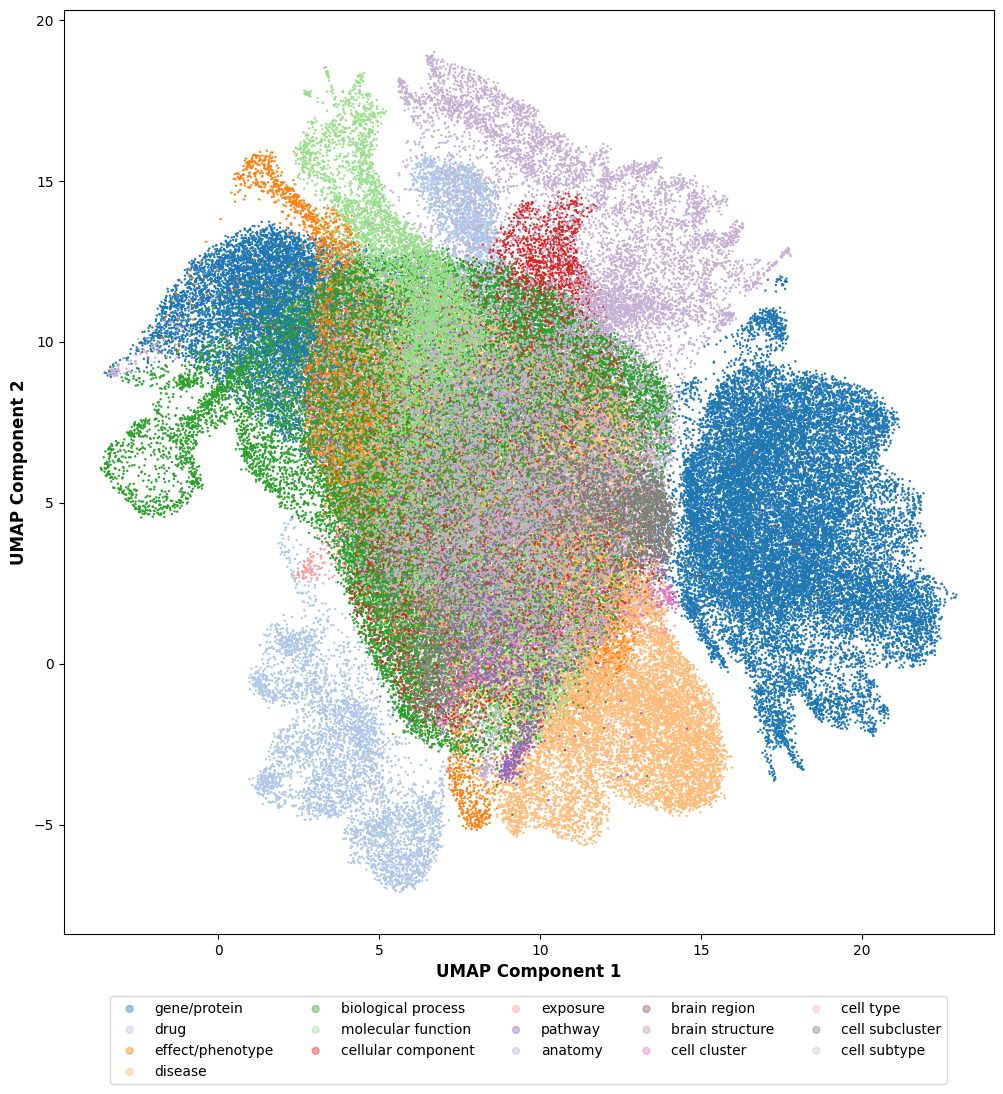

In [ ]:
# Get embedding UMAP name
embedding_UMAP_figure = conf.paths.checkpoint.checkpoint_path.name.replace(".ckpt", f"_embedding_{REDUCER}.pdf")
if REDUCER == "UMAP":
    embedding_UMAP_figure = embedding_UMAP_figure.replace(".pdf", f"_{UMAP_params_str}.pdf")

# Create scatter plot
plt.figure(figsize=(12, 12))
for node_type in node_types:
    plt.scatter(
        x=f"{REDUCER}_1",
        y=f"{REDUCER}_2",
        c="color",
        data=UMAP_results[UMAP_results["node_type"] == node_type],
        alpha=0.4,
        s=0.5,
        label=node_type_labels[node_type],
        zorder=3,
    )

# Set axis limits
plt.gca().set_aspect("equal", "datalim")

# Make legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.17), ncol=5, markerscale=7)

for handle in handles:
    handle.set_alpha(1)

# Set axis labels
plt.xlabel(f"{REDUCER} Component 1", fontsize=12, fontweight="bold")
plt.ylabel(f"{REDUCER} Component 2", fontsize=12, fontweight="bold")

# Save figure
plt.savefig(emb_ckpt_dir / embedding_UMAP_figure, format="pdf", bbox_inches="tight")
plt.savefig(emb_ckpt_dir / embedding_UMAP_figure.replace(".pdf", ".svg"), format="svg", bbox_inches="tight")
plt.savefig(emb_ckpt_dir / embedding_UMAP_figure.replace(".pdf", ".png"), format="png", bbox_inches="tight", dpi=900)
plt.show()

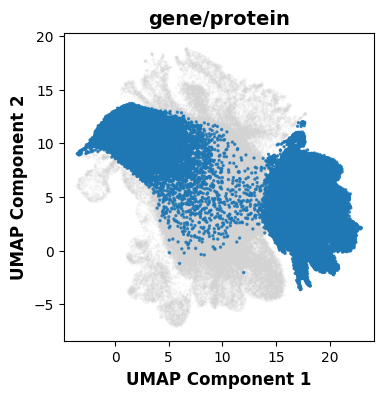

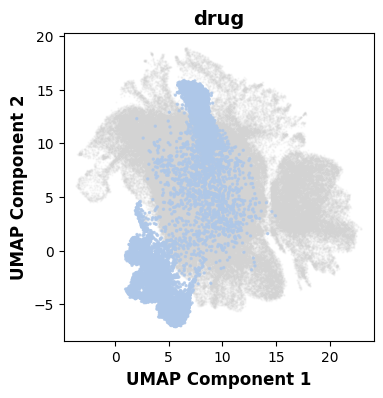

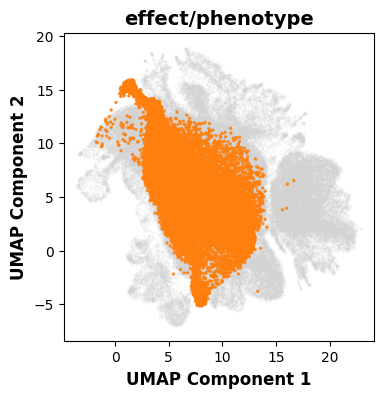

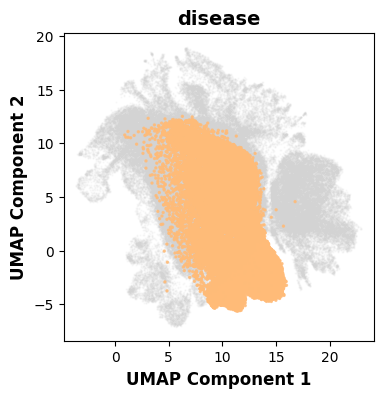

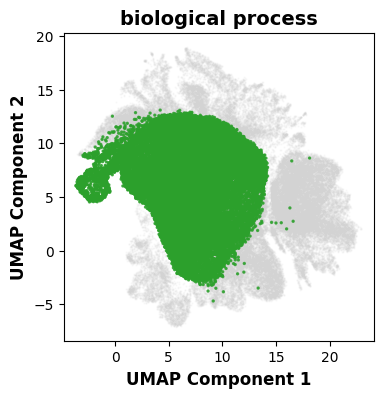

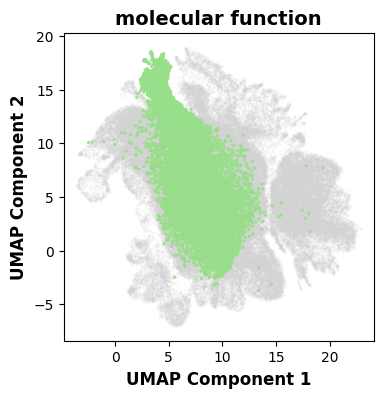

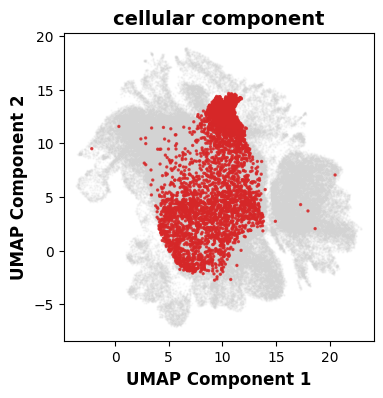

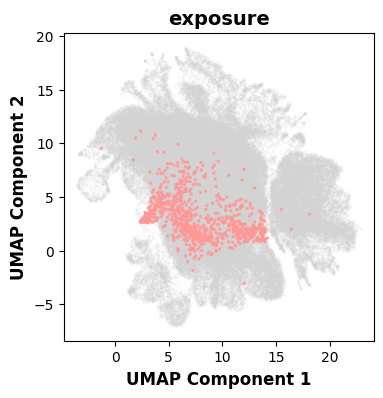

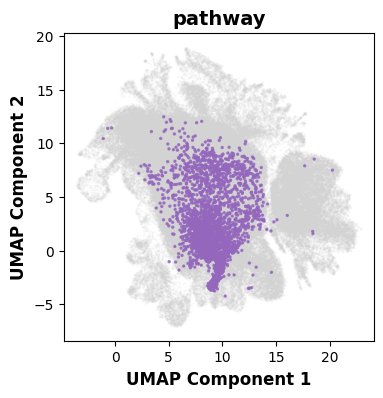

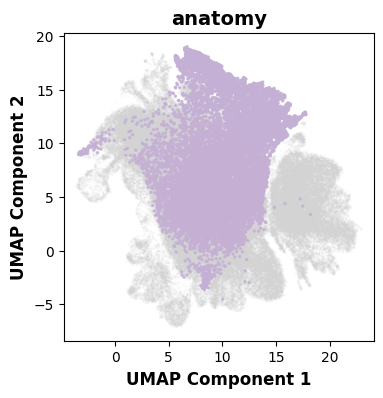

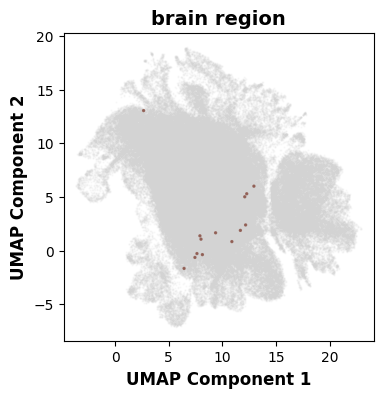

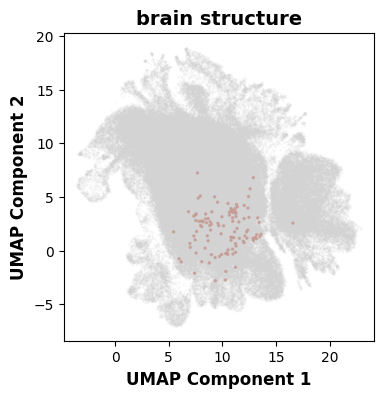

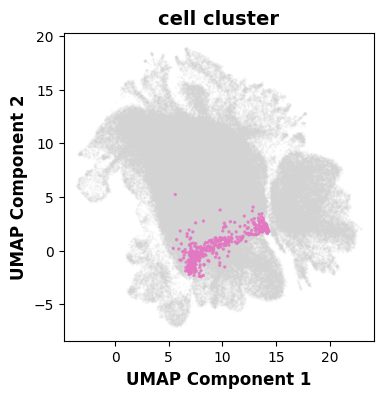

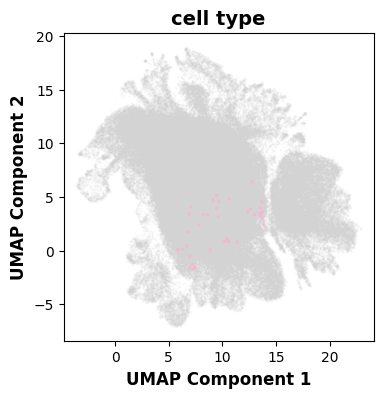

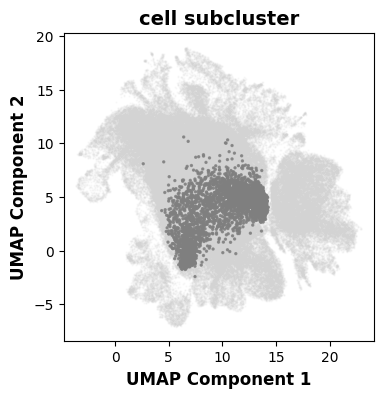

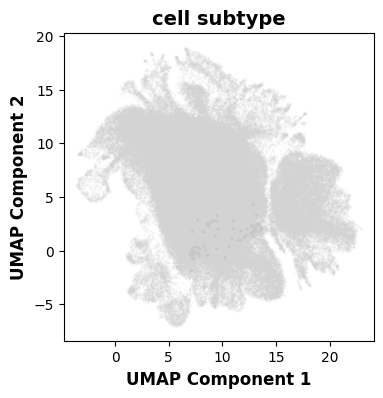

In [ ]:
node_types_to_plot = node_types
for node_type in node_types_to_plot:
    # Make node type specific figure
    plt.figure(figsize=(4, 4))

    # Plot all nodes except those in node type of interest
    plt.scatter(
        x=f"{REDUCER}_1",
        y=f"{REDUCER}_2",
        c="lightgray",
        data=UMAP_results[UMAP_results["node_type"] != node_type],
        alpha=0.1,
        s=0.5,
        label="Other",
        zorder=3,
    )

    # Plot nodes in node type of interest
    plt.scatter(
        x=f"{REDUCER}_1",
        y=f"{REDUCER}_2",
        c="color",
        data=UMAP_results[UMAP_results["node_type"] == node_type],
        alpha=0.8,
        s=2,
        label=node_type_labels[node_type],
        zorder=5,
    )
    plt.gca().set_aspect("equal", "datalim")

    # Set axis labels
    plt.xlabel(f"{REDUCER} Component 1", fontsize=12, fontweight="bold")
    plt.ylabel(f"{REDUCER} Component 2", fontsize=12, fontweight="bold")
    plt.title(node_type_labels[node_type], fontsize=14, fontweight="bold")

    # Define node type specific figure name
    clean_node_type = node_type.replace(" ", "_")
    clean_node_type = clean_node_type.replace("/", "_")
    ntype_umap_figure = embedding_UMAP_figure.replace(".pdf", f"_{clean_node_type}.pdf")

    # Save figure
    plt.savefig(emb_ckpt_dir / ntype_umap_figure, format="pdf", bbox_inches="tight")
    plt.savefig(emb_ckpt_dir / ntype_umap_figure.replace(".pdf", ".svg"), format="svg", bbox_inches="tight")
    # plt.savefig(emb_ckpt_dir / embedding_UMAP_figure.replace('.pdf', '.png'), format = 'png', bbox_inches = 'tight', dpi = 900)
    plt.show()

## Analyze Disease Groups

In [ ]:
# Define gene reducer
NTYPE_REDUCER = "UMAP"
NODE_TYPE = "disease"

# Subset to gene/protein embeddings
ntype_nodes = nodes[nodes["node_type"] == NODE_TYPE]
ntype_embeddings = embeddings[nodes["node_type"] == NODE_TYPE]
ntype_embeddings_df = pd.DataFrame(ntype_embeddings)

# Scale the embeddings
scaled_ntype_embeddings = StandardScaler().fit_transform(ntype_embeddings)

# Perform PCA on gene/protein embeddings
if NTYPE_REDUCER == "PCA":
    pca = PCA(n_components=2)
    pca_ntype_embeddings = pca.fit_transform(scaled_ntype_embeddings)
    dim_red_df = pd.DataFrame(pca_ntype_embeddings, columns=[f"{NTYPE_REDUCER}_1", f"{NTYPE_REDUCER}_2"])
# Perform UMAP on gene/protein embeddings
elif NTYPE_REDUCER == "UMAP":
    umap_ntype_embeddings = reducer.fit_transform(scaled_ntype_embeddings)
    dim_red_df = pd.DataFrame(umap_ntype_embeddings, columns=[f"{NTYPE_REDUCER}_1", f"{NTYPE_REDUCER}_2"])

# Concatenate node identifiers and UMAP embeddings
dim_red_df = pd.concat([ntype_nodes.reset_index(drop=True), dim_red_df.reset_index(drop=True)], axis=1)

Read MONDO disease file.

In [ ]:
mondo_dag = GODag(conf.paths.mondo_obo_path)

# See https://ols.monarchinitiative.org/ontologies/mondo
parents_of_interest = {
    "neurodegenerative disease": "http://purl.obolibrary.org/obo/MONDO_0005559",
    "cancer": "http://purl.obolibrary.org/obo/MONDO_0004992",
    "infectious disease": "http://purl.obolibrary.org/obo/MONDO_0005550",
}

parents_of_interest = {
    key: value.replace("http://purl.obolibrary.org/obo/MONDO_", "MONDO:") for key, value in parents_of_interest.items()
}

data/mondo/mondo.obo: fmt(1.2) rel(2023-04-04) 23,151 Terms


In [ ]:
category_to_mondo_set = {}
category_to_disease_names = {}
for cat_name, parent_mondo_id in parents_of_interest.items():
    if parent_mondo_id not in mondo_dag:
        _logger.info(f"[WARNING] {parent_mondo_id} not found in mondo.obo. Skipping.")
        continue

    parent_term = mondo_dag[parent_mondo_id]

    # get_all_children() returns all descendants; also include the parent itself
    all_descendants = parent_term.get_all_children()
    mondo_ids = set(all_descendants)
    mondo_ids.add(parent_mondo_id)
    category_to_mondo_set[cat_name] = mondo_ids

    # Get names of diseases in each category
    disease_names = [mondo_dag[mondo_id].name for mondo_id in mondo_ids]
    category_to_disease_names[cat_name] = disease_names

# Print number of diseases in each category
for cat_name, mondo_ids in category_to_mondo_set.items():
    _logger.info(f"{cat_name}: {len(mondo_ids)}")

# Check overlap between categories
_logger.info("\nChecking overlap between categories...")
overlapping_diseases = set()
for cat1 in category_to_mondo_set:
    for cat2 in category_to_mondo_set:
        if cat1 == cat2:
            continue
        _logger.info(f"{cat1} and {cat2} overlap: {len(category_to_mondo_set[cat1] & category_to_mondo_set[cat2])}")
        overlapping_diseases.update(category_to_mondo_set[cat1] & category_to_mondo_set[cat2])

# Drop overlapping diseases
for cat_name in category_to_mondo_set:
    category_to_mondo_set[cat_name] = category_to_mondo_set[cat_name] - overlapping_diseases

# Print number of diseases in each category
_logger.info("\nAfter dropping overlapping diseases:")
for cat_name, mondo_ids in category_to_mondo_set.items():
    _logger.info(f"{cat_name}: {len(mondo_ids)}")

[12/04/25 19:37:41] INFO     neurodegenerative disease: 772                                        ]8;id=415261;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=123721;file:///tmp/ipykernel_3127853/3006512009.py#22\22]8;;\

                    INFO     cancer: 2208                                                          ]8;id=177216;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=206111;file:///tmp/ipykernel_3127853/3006512009.py#22\22]8;;\

                    INFO     infectious disease: 1060                                              ]8;id=465168;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=73787;file:///tmp/ipykernel_3127853/3006512009.py#22\22]8;;\

                    INFO                                                                           ]8;id=564154;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=548929;file:///tmp/ipykernel_3127853/3006512009.py#25\25]8;;\
                             Checking overlap between categories...                                                

                    INFO     neurodegenerative disease and cancer overlap: 0                       ]8;id=723508;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=326188;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO     neurodegenerative disease and infectious disease overlap: 22          ]8;id=810784;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=916557;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO     cancer and neurodegenerative disease overlap: 0                       ]8;id=350355;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=172445;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO     cancer and infectious disease overlap: 10                             ]8;id=596546;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=45693;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO     infectious disease and neurodegenerative disease overlap: 22          ]8;id=79421;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=415026;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO     infectious disease and cancer overlap: 10                             ]8;id=368226;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=404815;file:///tmp/ipykernel_3127853/3006512009.py#31\31]8;;\

                    INFO                                                                           ]8;id=555673;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=851553;file:///tmp/ipykernel_3127853/3006512009.py#39\39]8;;\
                             After dropping overlapping diseases:                                                  

                    INFO     neurodegenerative disease: 750                                        ]8;id=957757;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=983477;file:///tmp/ipykernel_3127853/3006512009.py#41\41]8;;\

                    INFO     cancer: 2198                                                          ]8;id=132649;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=719953;file:///tmp/ipykernel_3127853/3006512009.py#41\41]8;;\

                    INFO     infectious disease: 1028                                              ]8;id=306253;file:///tmp/ipykernel_3127853/3006512009.py\3006512009.py]8;;\:]8;id=85035;file:///tmp/ipykernel_3127853/3006512009.py#41\41]8;;\

Construct disease groups.

In [ ]:
dim_red_df["category"] = "other"

# Assign category to each disease
for i, row in dim_red_df.iterrows():
    mondo_id = row["node_id"]

    # Pad with up to 7 leading zeroes
    mondo_id = "MONDO:" + mondo_id.zfill(7)
    assigned_cat = None
    for cat_name, mondo_ids in category_to_mondo_set.items():
        if mondo_id in mondo_ids:
            assigned_cat = cat_name
            break
    if assigned_cat is not None:
        dim_red_df.at[i, "category"] = assigned_cat

dim_red_df["category"].value_counts()


category
other                        18409
cancer                        2117
infectious disease             982
neurodegenerative disease      693
Name: count, dtype: int64

Define colors for each category.

In [ ]:
unique_cats = dim_red_df["category"].unique()
category_color_map = {}
cmap = plt.get_cmap("tab10") if len(unique_cats) > 4 else ["lightgray", "#ef476f", "#0ead69", "#1e96fc"]

for idx, cat in enumerate(unique_cats):
    if len(unique_cats) > 4:
        category_color_map[cat] = cmap(idx / len(unique_cats))
    else:
        category_color_map[cat] = cmap[idx]

# Assign other as gray
category_color_map["other"] = "lightgray"

Plot dimensionality reduction of node type embeddings.

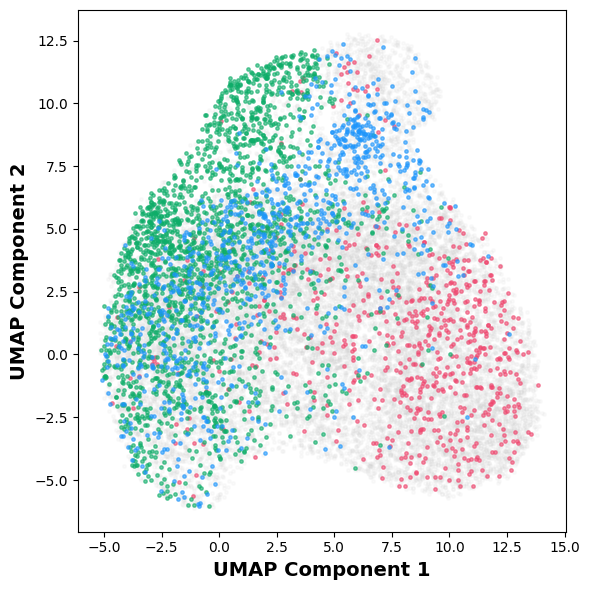

In [ ]:
# Get figure name
ntype_umap_figure = conf.paths.checkpoint.checkpoint_path.name.replace(
    ".ckpt", f"_embedding_{NODE_TYPE}_{NTYPE_REDUCER}.pdf"
)

# Plot UMAP of node type embeddings
plt.figure(figsize=(6, 6))

for cat in unique_cats:
    subdf = dim_red_df[dim_red_df["category"] == cat]
    alpha_val = 0.1 if cat == "other" else 0.6
    plt.scatter(
        subdf[f"{NTYPE_REDUCER}_1"],
        subdf[f"{NTYPE_REDUCER}_2"],
        label=cat,
        c=[category_color_map[cat]],
        s=6,
        alpha=alpha_val,
    )

plt.xlabel(f"{NTYPE_REDUCER} Component 1", fontsize=14, fontweight="bold")
plt.ylabel(f"{NTYPE_REDUCER} Component 2", fontsize=14, fontweight="bold")
plt.tight_layout()

# Save figure
plt.savefig(emb_ckpt_dir / ntype_umap_figure, format="pdf", bbox_inches="tight")
plt.savefig(emb_ckpt_dir / ntype_umap_figure.replace(".pdf", ".svg"), format="svg", bbox_inches="tight")
plt.savefig(emb_ckpt_dir / ntype_umap_figure.replace(".pdf", ".png"), format="png", bbox_inches="tight", dpi=900)
plt.show()

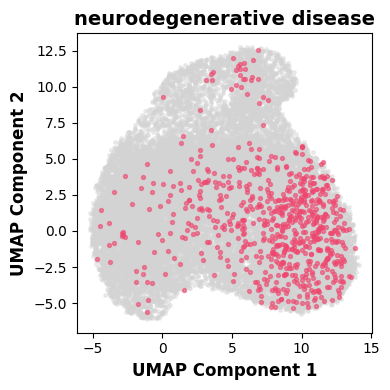

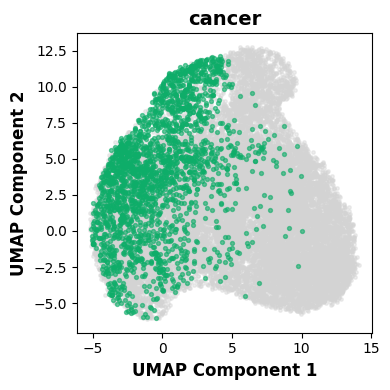

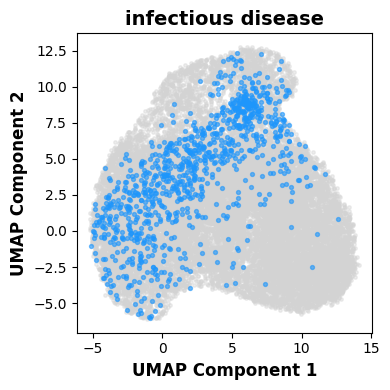

In [ ]:
for cat in unique_cats:
    if cat == "other":
        continue

    # Create subset data for the current category and "others"
    subdf_cat = dim_red_df[dim_red_df["category"] == cat]
    subdf_others = dim_red_df[dim_red_df["category"] != cat]

    # Create a new figure for this category
    plt.figure(figsize=(4, 4))

    # Plot all other disease nodes in gray
    plt.scatter(
        subdf_others[f"{NTYPE_REDUCER}_1"],
        subdf_others[f"{NTYPE_REDUCER}_2"],
        color="lightgray",
        alpha=0.4,
        s=6,
        label="Other categories",
    )

    # Plot the current category
    plt.scatter(
        subdf_cat[f"{NTYPE_REDUCER}_1"],
        subdf_cat[f"{NTYPE_REDUCER}_2"],
        color=category_color_map[cat],
        alpha=0.6,
        s=8,
        label=cat,
    )

    # Label axes
    plt.xlabel(f"{NTYPE_REDUCER} Component 1", fontsize=12, fontweight="bold")
    plt.ylabel(f"{NTYPE_REDUCER} Component 2", fontsize=12, fontweight="bold")

    plt.title(cat, fontsize=14, fontweight="bold")
    plt.tight_layout()

    # Get figure name
    ntype_cat_figure = ntype_umap_figure.replace(".pdf", f"_{cat}.pdf")

    # Save figure
    plt.savefig(emb_ckpt_dir / ntype_cat_figure, format="pdf", bbox_inches="tight")
    plt.savefig(emb_ckpt_dir / ntype_cat_figure.replace(".pdf", ".svg"), format="svg", bbox_inches="tight")
    plt.savefig(emb_ckpt_dir / ntype_cat_figure.replace(".pdf", ".png"), format="png", bbox_inches="tight", dpi=900)
    plt.show()

Compute silhouette score.

In [ ]:
# Set seed
np.random.seed(42)

dim_red_subset = dim_red_df
dim_red_embeds = embeddings[dim_red_subset["node_index"].values]

# Create pairwise similarity matrix
_logger.info("Computing cosine similarity...")
cos_sim_ntype_embds = cosine_similarity(dim_red_embeds)

# Apply min-max scaling over whole matrix
cos_sim_ntype_embds = (cos_sim_ntype_embds - cos_sim_ntype_embds.min()) / (
    cos_sim_ntype_embds.max() - cos_sim_ntype_embds.min()
)

# Print range of values
_logger.info(f"Min: {cos_sim_ntype_embds.min()}, Max: {cos_sim_ntype_embds.max()}")

# Convert to distance matrix
_logger.info("Converting to distance matrix...")
dist_ntype_embds = 1 - cos_sim_ntype_embds

# Compute silhouette score
_logger.info("Computing silhouette score...")
global_silhouette_score = silhouette_score(dist_ntype_embds, dim_red_subset["category"], metric="precomputed")
_logger.info(f"Global silhouette score: {global_silhouette_score}")  # -0.16999608278274536

# Compute silhouette score for each category
_logger.info("\nComputing silhouette score for each category...")
sample_silhouette_scores = silhouette_samples(dist_ntype_embds, dim_red_subset["category"], metric="precomputed")
dim_red_subset["silhouette_score"] = sample_silhouette_scores

[12/04/25 19:37:56] INFO     Computing cosine similarity...                                         ]8;id=935357;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=2378;file:///tmp/ipykernel_3127853/4184038063.py#8\8]8;;\

[12/04/25 19:38:04] INFO     Min: 0.0, Max: 1.0                                                    ]8;id=729620;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=694914;file:///tmp/ipykernel_3127853/4184038063.py#17\17]8;;\

                    INFO     Converting to distance matrix...                                      ]8;id=739450;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=641477;file:///tmp/ipykernel_3127853/4184038063.py#20\20]8;;\

[12/04/25 19:38:05] INFO     Computing silhouette score...                                         ]8;id=347671;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=546263;file:///tmp/ipykernel_3127853/4184038063.py#24\24]8;;\

[12/04/25 19:38:08] INFO     Global silhouette score: -0.1421026587486267                          ]8;id=419633;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=531875;file:///tmp/ipykernel_3127853/4184038063.py#26\26]8;;\

                    INFO                                                                           ]8;id=751296;file:///tmp/ipykernel_3127853/4184038063.py\4184038063.py]8;;\:]8;id=4210;file:///tmp/ipykernel_3127853/4184038063.py#29\29]8;;\
                             Computing silhouette score for each category...                                       

In [ ]:
# Compute average silhouette score for each category
mean_silhouette_scores = dim_red_subset.groupby("category")["silhouette_score"].mean().sort_values(ascending=False)

# Compute standard deviation of silhouette score for each category
std_silhouette_scores = dim_red_subset.groupby("category")["silhouette_score"].std().sort_values(ascending=False)

# Compute number of points in each category
n_points_per_cat = dim_red_subset.groupby("category").size().sort_values(ascending=False)
mean_silhouette_scores.head()


category
neurodegenerative disease    0.187437
cancer                       0.133058
infectious disease           0.025485
other                       -0.195091
Name: silhouette_score, dtype: float32

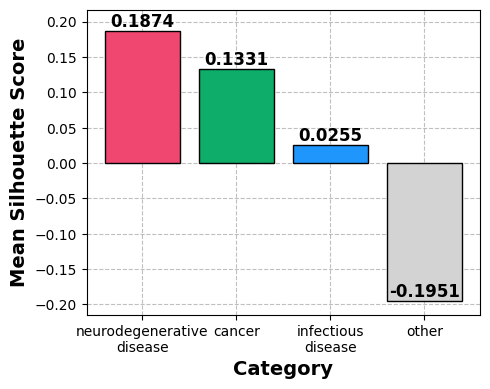

In [ ]:
category_color_map["random"] = "lightgray"
ordered_cats = mean_silhouette_scores.index.tolist()
mean_silhouette_scores_colors = {cat: category_color_map.get(cat, "lightgray") for cat in ordered_cats}
mean_silhouette_scores_keys = [cat.replace(" ", "\n") for cat in ordered_cats]

# Create bar plot
plt.figure(figsize=(5, 4))

x_vals = range(len(ordered_cats))
plt.bar(
    x_vals,
    mean_silhouette_scores.values,
    # yerr=std_silhouette_scores.values,  # standard deviation as error bars
    color=[mean_silhouette_scores_colors[cat] for cat in ordered_cats],
    edgecolor="black",
    capsize=4,  # adds caps on the error bars
    zorder=3,
)

# Labeling and aesthetics
plt.xticks(x_vals, mean_silhouette_scores_keys, rotation=0)
plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Mean Silhouette Score", fontsize=14, fontweight="bold")
plt.tight_layout()

# Add the numeric value (mean silhouette) on top of each bar
for i, (cat, score) in enumerate(mean_silhouette_scores.items()):
    plt.text(i, score, f"{score:.4f}", ha="center", va="bottom", fontsize=12, fontweight="bold")

# Expand y-axis limits slightly
plt.ylim(plt.ylim()[0], plt.ylim()[1] * 1.05)

# Add a dashed grid behind bars
plt.grid(color="gray", linestyle="dashed", alpha=0.5, zorder=0)

# Save figure
mean_silhouette_scores_figure = ntype_umap_figure.replace(".pdf", "_mean_silhouette.pdf")
plt.savefig(emb_ckpt_dir / mean_silhouette_scores_figure, format="pdf", bbox_inches="tight")
plt.savefig(emb_ckpt_dir / mean_silhouette_scores_figure.replace(".pdf", ".svg"), format="svg", bbox_inches="tight")
plt.savefig(
    emb_ckpt_dir / mean_silhouette_scores_figure.replace(".pdf", ".png"), format="png", bbox_inches="tight", dpi=900
)

plt.show()